# Casusopdracht - Onderzoeksvraag 1

*Klas*: V2B
*Studenten*: 
- Roan Gaasbeek
- Luc Pikaar
- Mathijs de Jong


Dit bestand bouwt voort op de algemene stappen die zijn uitgevoerd in het bestand `CM_casusopdracht.ipynb`. In dat bestand zijn de fasen **Business Understanding**, **Data Understanding** en **Algemene Data Preparation** behandeld. In dit bestand gaan we verder met **Data Preparation** specifiek voor deze onderzoeksvraag en starten we de **Modelling**-fase.

## 1. Business Understanding

### Onderzoeksvraag
In hoeverre is de bruto-omzet van een film te voorspellen op basis van de populariteit op **Facebook** en **IMDB**?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso



In [2]:
# De schone dataset inladen
dataset = pd.read_csv('films.csv')


## Correlation Analysis

### Facebook Likes

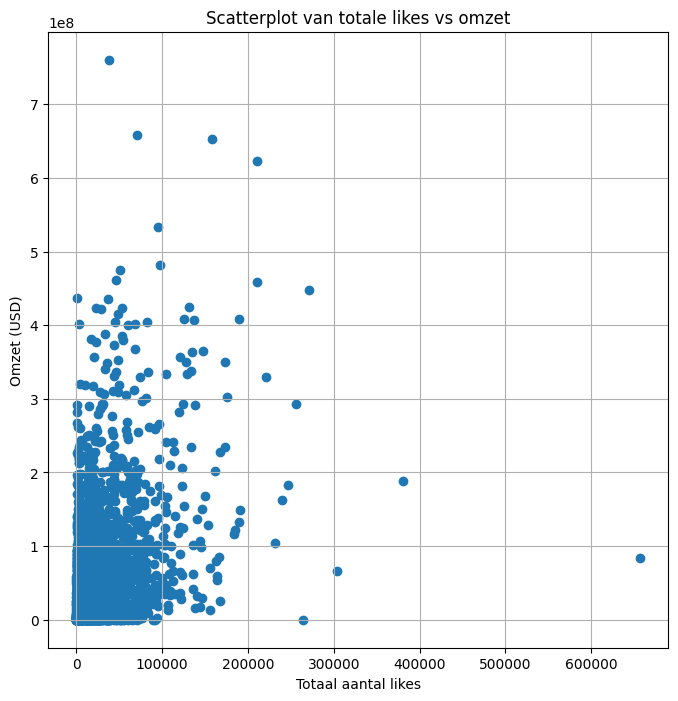

De correlatie is 0.3845780822899516


In [3]:
# TODO: beschrijving in markdown erboven
dataset['totaal_likes'] = dataset['cast_totaal_likes'] + dataset['film_likes']
plt.figure(figsize=(8, 8))
plt.scatter(dataset['totaal_likes'], dataset['omzet'])
plt.title('Scatterplot van totale likes vs omzet')
plt.xlabel('Totaal aantal likes')
plt.ylabel('Omzet (USD)')
plt.grid(True)
plt.show()
correlatie = np.corrcoef(dataset['totaal_likes'], dataset['omzet'])[0,1]
print(f"De correlatie is {correlatie}")

### Budget

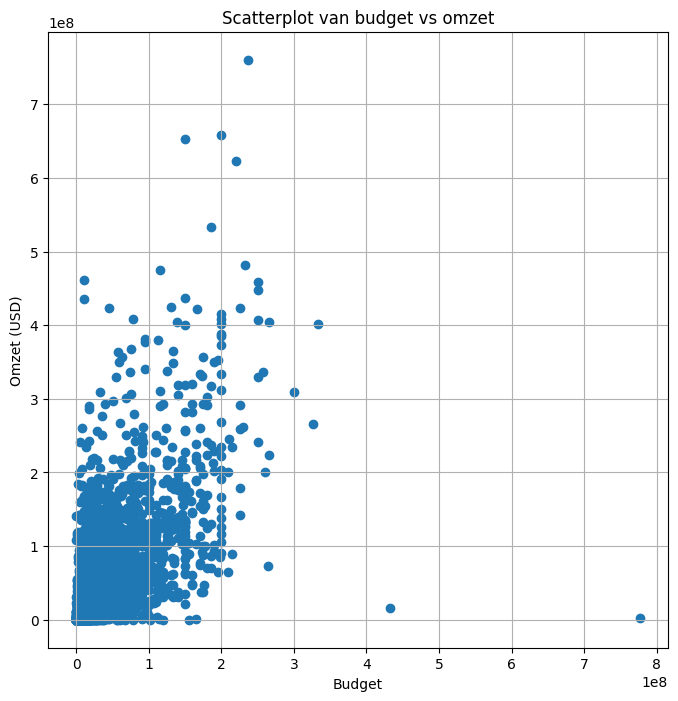

De correlatie is 0.6204341240303214


In [4]:
# TODO: beschrijving in markdown erboven
plt.figure(figsize=(8, 8))

data = dataset[['budget', 'omzet']].dropna() #TODO: dit moet nog in cleaning opgelost worden

plt.scatter(data['budget'], data['omzet'])
plt.title('Scatterplot van budget vs omzet')
plt.xlabel('Budget')
plt.ylabel('Omzet (USD)')
plt.grid(True)
plt.show()
correlatie = np.corrcoef(data['budget'], data['omzet'])[0,1]
print(f"De correlatie is {correlatie}")

### IMDB Score

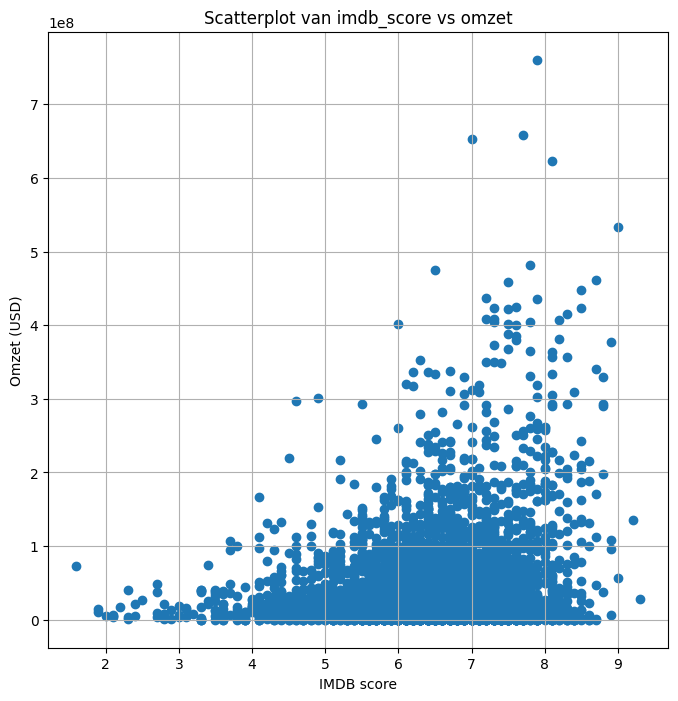

De correlatie is 0.21585758959866475


In [5]:
# TODO: beschrijving in markdown erboven
plt.figure(figsize=(8, 8))
plt.scatter(dataset['imdb_score'], dataset['omzet'])
plt.title('Scatterplot van imdb_score vs omzet')
plt.xlabel('IMDB score')
plt.ylabel('Omzet (USD)')
plt.grid(True)
plt.show()
correlatie = np.corrcoef(dataset['imdb_score'], dataset['omzet'])[0,1]
print(f"De correlatie is {correlatie}")

### Acteur 

Door films te herstructureren naar individuele film-acteur combinaties, kun je `acteur`-specifieke invloed op het succes van de film onderzoeken. Je kunt films clusteren op basis van de Facebook-likes van individuele acteurs en de bijbehorende filmomzet, en vervolgens patronen analyseren zoals welke acteurs de meeste invloed hebben op commerciële successen.

In [6]:
actor_dataset = dataset[['titel', 'acteur_1', 'acteur_2', 'acteur_3', 'acteur_1_likes', 'acteur_2_likes', 'acteur_3_likes', 'omzet']]

# Reshape the DataFrame
actor_data = pd.DataFrame({
    'titel': actor_dataset['titel'].values.repeat(3),
    'acteur': actor_dataset[['acteur_1', 'acteur_2', 'acteur_3']].values.flatten(),
    'likes': actor_dataset[['acteur_1_likes', 'acteur_2_likes', 'acteur_3_likes']].values.flatten(),
    'omzet': actor_dataset['omzet'].values.repeat(3)
}).dropna()

actor_data.head()

,titel,acteur,likes,omzet
0,Avatar,CCH Pounder,1000.0,760505847.0
1,Avatar,Joel David Moore,936.0,760505847.0
2,Avatar,Wes Studi,855.0,760505847.0
3,Pirates of the Caribbean: At World's End,Johnny Depp,40000.0,309404152.0
4,Pirates of the Caribbean: At World's End,Orlando Bloom,5000.0,309404152.0


In [7]:
idx = actor_data.groupby('titel')['likes'].idxmax()

# Selecteer alleen de rijen met de meeste likes per film
actor_data = actor_data.loc[idx].reset_index(drop=True)
actor_data.head()

,titel,acteur,likes,omzet
0,10 Cloverfield Lane,Bradley Cooper,14000.0,71897215.0
1,10 Days in a Madhouse,Christopher Lambert,1000.0,14616.0
2,10 Things I Hate About You,Joseph Gordon-Levitt,23000.0,38176108.0
3,102 Dalmatians,Ioan Gruffudd,2000.0,66941559.0
4,10th & Wolf,Brian Dennehy,954.0,53481.0


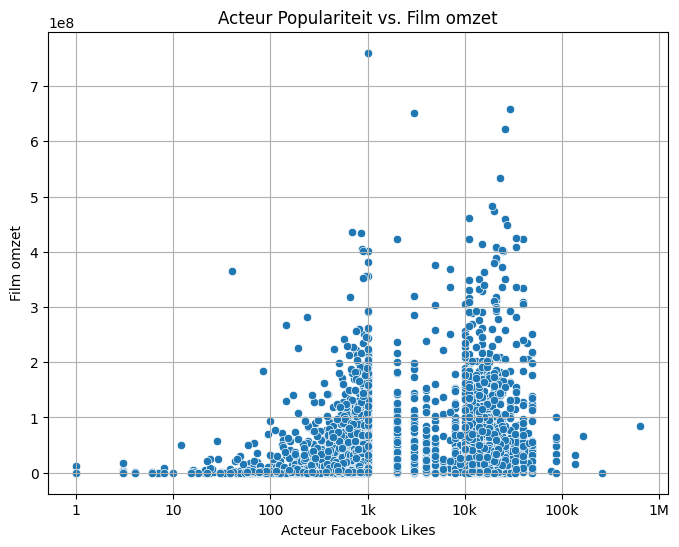

De correlatie is 0.26551039192668346


In [8]:
# Scatter plot: Likes vs Gross
plt.figure(figsize=(8, 6))

# Maak een nieuwe kolom met log10 van likes
actor_data['log_likes'] = np.log10(actor_data['likes'] + 1)  # +1 om log(0) te vermijden

# Scatterplot met log10 op de x-as
sns.scatterplot(x='log_likes', y='omzet', data=actor_data)

plt.title('Acteur Populariteit vs. Film omzet')
plt.xlabel('Acteur Facebook Likes')
plt.ylabel('Film omzet')
plt.grid(True)
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=["1", "10", "100", "1k", "10k", "100k", "1M"])  # Labels voor x-as
plt.show()

correlatie = np.corrcoef(actor_data['log_likes'], actor_data['omzet'])[0,1]
print(f"De correlatie is {correlatie}")


## Train test split voor baseline en regressie model

In [10]:
# Hier kiezen we onze features en het target. Daarnaast splitsen we de training en validatie.

features = dataset[['imdb_score', 'film_likes', 'directeur_likes', 
        'acteur_1_likes', 'acteur_2_likes', 
        'acteur_3_likes', 'cast_totaal_likes']]

target = dataset['omzet']

features_train, features_val, target_train, target_val = train_test_split(features, target, random_state=70, test_size=0.23)
print("Training set:", features_train.shape, target_train.shape)
print("Validatie set:", features_val.shape, target_val.shape)

Training set: (2909, 7) (2909,)
Validatie set: (870, 7) (870,)


### Baseline model

In [11]:
# In het baseline model berekenen we het gemiddelde uit van het target. We gebruiken een baseline model om te vergelijken met het
# supervised learning model.

gemiddelde_baseline = target_train.mean()

baseline_voorspelling = [gemiddelde_baseline] * len(target_val)

baseline_r2 = r2_score(target_val, baseline_voorspelling)
score = baseline_r2 * 100
print(f"R2 score: {score:.2f}%")

R2 score: -0.03%


Een score van -0.03% betekent dat het model slechter voorspelt dan het gemiddelde. Het baseline model is daarom geen goed model om de target variabele 'gross' te voorspellen. 

### Supervised learning model

In [12]:
model = LinearRegression()
model.fit(features_train, target_train)
pd.DataFrame(model.coef_, features.columns, columns = ['Coeff'])

target_pred = model.predict(features_val)
r2 = r2_score(target_val, target_pred)
score_percentage = r2 * 100
print(f"R2 score: {score_percentage:.2f}%")

R2 score: 29.10%


In [14]:
mse = ((target_pred - target_val) ** 2).mean()
print(mse)
rmse = np.sqrt(mse)
print(f"RMSE score: {rmse}")

3356306640090297.0
RMSE score: 57933639.969281204


Wat betekent een R² score van 29% precies?
Een R² van 0.29 betekent dat het model slechts 29% van de variatie in de afhankelijke variabele in dit geval omzet verklaart. Dit betekent dat 71% van de variatie niet wordt verklaard door het model en door andere factoren komt. 

R² = 1 (100%) betekent dat het model perfect past en alle variatie in de data verklaart.
R² = 0 (0%) betekent dat het model helemaal geen verklaring biedt voor de variatie in de data. Dit is even 'slecht' als het gemiddelde.

Zoals hier boven te zien zit het model er redelijk vaak naast en enkele keren in de buurt. De conclusie die wij hieruit trekken is dat dit model met een score van 29% niet betrouwbaar is om de omzet te voorspellen.

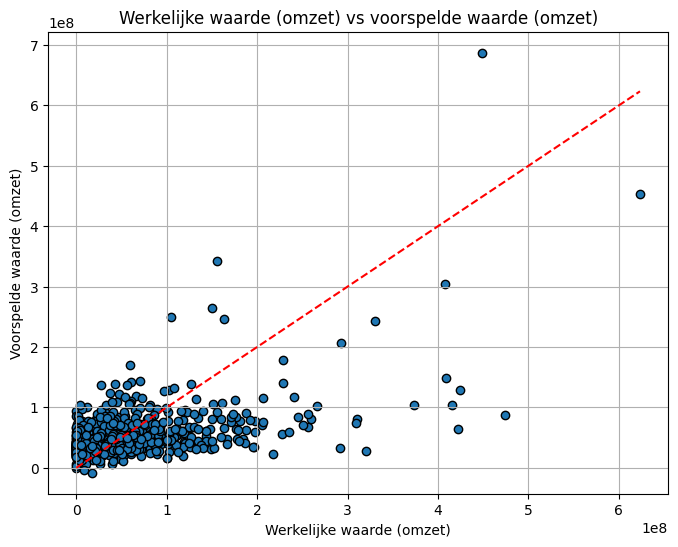

In [15]:
plt.figure(figsize=(8,6))

plt.scatter(target_val, target_pred, edgecolor='k')

#Diagonale rode lijn die de perfecte voorspelling laat zien
plt.plot([target_val.min(), target_val.max()], [target_val.min(), target_val.max()], color='red', linestyle='--')

plt.title('Werkelijke waarde (omzet) vs voorspelde waarde (omzet)')
plt.xlabel('Werkelijke waarde (omzet)')
plt.ylabel('Voorspelde waarde (omzet)')
plt.grid(True)
plt.show()


De rode lijn in het plot is de perfect voorspelde waarde. In het plot kan je zien dat bij een lagere bruto inkomst het model beter werkt en naarmate de gross hoger wordt het steeds minder goed werkt.